In [19]:
from serde.json import from_json, to_json
from rich.table import Table
from rich import print
import json
import sklearn
import random
import numpy as np
import pandas as pd
from joblib import load, dump
import time

In [213]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import preprocessing, utils
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif


from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [214]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
%matplotlib inline

# Machine learning Classification

In [6]:
data_cls = pd.read_csv("data_nettoyee_classe.csv") ##Import base de données
data_cls = data_cls.replace(np.NaN, True) ##Seul les mac manquait des valeurs pour hdmi,camera et usb
data_cls = data_cls*1 ##Pour mettre en binaire les true et false
data_cls = data_cls.drop(columns={"index", "Résolution"}) 

### Data Visualisation

In [217]:
sns.set_theme(style="ticks",
              color_codes=True)

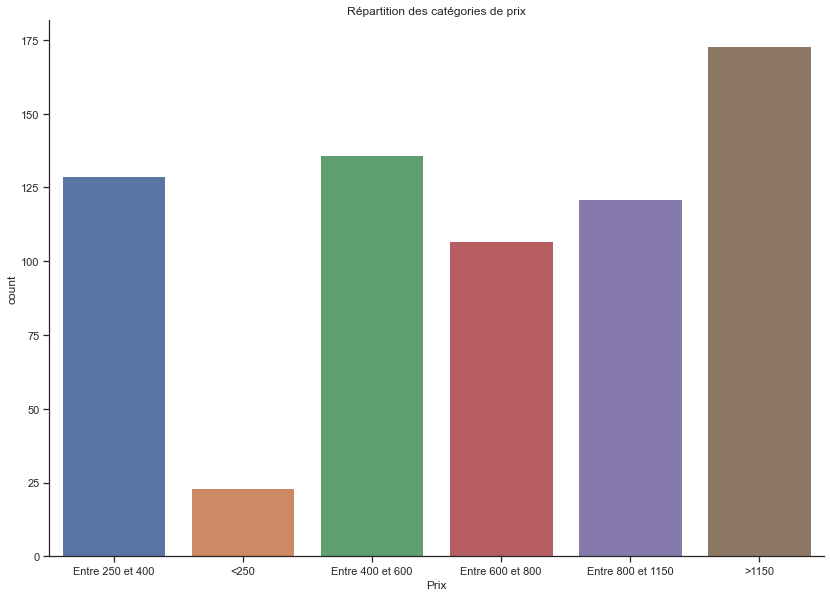

In [218]:
sns.catplot(x="Prix",
            kind="count",
            data=data_cls,
            height=8.27, aspect=11.7/8.27).set(title = "Répartition des catégories de prix")

On remarque que les classes sont plutot équivalentes, sauf pour "<250", mais ca me semblait intéressant de commencer les classes à 250 euros. Une autre remarque est que l'on a beaucoup de PC portbale avec un prix élevé.

[Text(0.5, 1.0, 'Répartition des marques')]

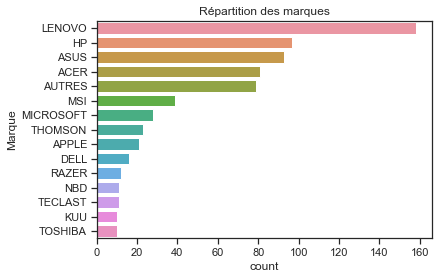

In [219]:
sns.countplot(y="Marque", data=data_cls,
             order = data_cls['Marque'].value_counts().index).set(title = "Répartition des marques")

La marque la plus représenté est LENOVO suivi par HP et ASUS. 

col_0,count
RAM,
1,1
2,16
3,4
4,140
6,19
8,364
16,134
64,5
128,2


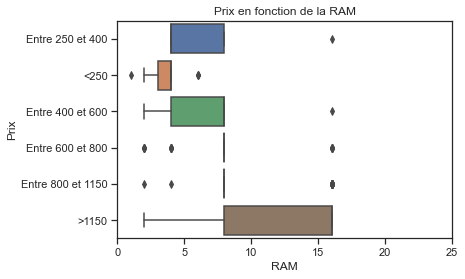

In [220]:
sns.boxplot(y=data_cls["Prix"],
            x=data_cls["RAM"]).set(title="Prix en fonction de la RAM", xlim=(0, 25))

tab_RAM = pd.crosstab(index = data_cls["RAM"],
                              columns="count")
tab_RAM.head(10)

La plupart des PC ont une RAM entre 4 et 16 Go. Toutefois on remarque que plus le PC est cher, plus sa RAM semble être importante. Cela va aider dans la classification.

col_0,count
Stockage,
4,1
8,3
32,15
64,64
128,61


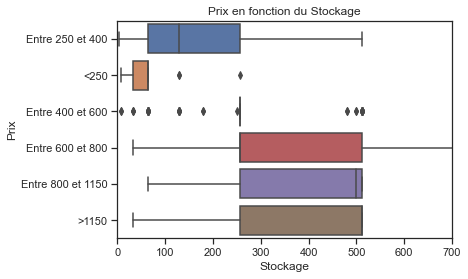

In [221]:
sns.boxplot(y=data_cls["Prix"],
            x=data_cls["Stockage"]).set(title="Prix en fonction du Stockage",
                                        xlim=(0, 700))

tab_Stockage = pd.crosstab(index = data_cls["Stockage"],
                              columns="count")
tab_Stockage.head()

De même que pour la RAM, le stockage maximale est plus important quand le PC coûte plus cher. Toutefois il semble difficile de différencier les PC entre 600 et 1150+ euros.

[Text(0.5, 1.0, 'Répartition des Processeur')]

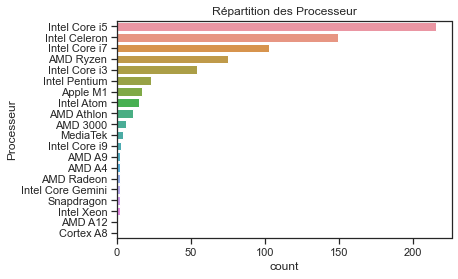

In [222]:
sns.countplot(y="Processeur", data=data_cls,
             order = data_cls['Processeur'].value_counts().index).set(title = "Répartition des Processeur")

[Text(0.5, 1.0, 'Prix en fonction de la taille'), (10.0, 18.0)]

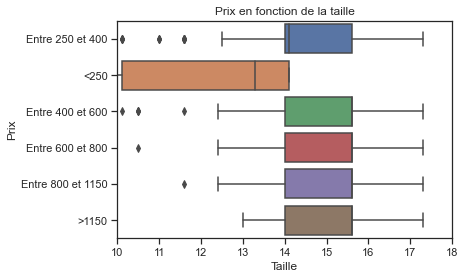

In [223]:
sns.boxplot(y=data_cls["Prix"],
            x=data_cls["Taille"]).set(title="Prix en fonction de la taille",
                                      xlim=(10, 18))

On remarque seulement sur ce graphique que les PC peut cher sont plus petits.
Pour le reste la taille semble standard

[Text(0.5, 1.0, 'Prix en fonction du Poids'), (0.3, 4.0)]

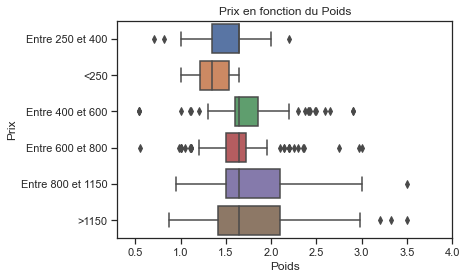

In [224]:
sns.boxplot(y=data_cls["Prix"],
            x=data_cls["Poids"]).set(title="Prix en fonction du Poids",
                                     xlim=(0.3, 4))

Le poids n'impacte pas tant que ca le prix malgrès un poids plus faible entre 0 et 400 euros que pour un prix > 400 euros. 

## Machine learning models

Premièrement, on utilise la fonction 'get_dummies' de pandas pour les variables système d'exploitation, Marque et Processeur. Cela va creer des colonnes et mettre 1 si l'observation appartient à la catégorie et 0 sinon.

In [7]:
data_cls = pd.get_dummies(data_cls,
                          columns=["Systeme_exploitation","Marque", "Processeur"],
                          drop_first=False)

In [8]:
def select_features(X_train, y_train, X_test):
    """Fonction permettant de choisir le nombre de features (colonnes) que l'on utilisera pour les
        modèle de Machine learning. Pren en input les donnees test et train pour avoir en output
        les donnees test et train avec le bon nombres de colonnes (features).
    """
    fs = SelectKBest(score_func=chi2, k=40)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [9]:
Y = data_cls["Prix"]
X = data_cls.drop("Prix", axis=1)

In [10]:
#Decoupage des données en test et train
random.seed(1)
X_tr, X_te, y_tr, y_te = train_test_split(X, Y)

In [11]:
X_train_fs, X_test_fs, fs = select_features(X_tr, y_tr, X_te)

In [12]:
#Pour stocker les résultats des modèles.
resultats = dict()

In [177]:
Dummy = DummyClassifier(strategy="most_frequent")
Dummy_score = cross_val_score(
    Dummy, 
    X_train_fs, 
    y_tr,
)
resultats["DummyClassifier"] = np.mean(Dummy_score)

In [178]:
c = KNeighborsClassifier()
g = GridSearchCV(
    estimator=c,
    param_grid={
        "n_neighbors": [3, 5, 7, 9],
    }
)
g.fit(X_train_fs, y_tr)
resultats[g] = g.best_score_

In [179]:
c = GaussianNB()
score = cross_val_score(c, X_train_fs, y_tr)
resultats["Gaussia NB"] = np.mean(score)

In [180]:
c = MultinomialNB()
score = cross_val_score(c, X_train_fs, y_tr)
resultats["MultinomialNB"] = np.mean(score)

In [181]:
c = DecisionTreeClassifier()
score = cross_val_score(c, X_train_fs, y_tr)
resultats["Decision Tree"] = np.mean(score)

In [187]:
c = RandomForestClassifier()
g = GridSearchCV(
    estimator=c,
    param_grid={
        "n_estimators": [50, 100, 200, 400, 800],
        "max_features": ['auto', 'sqrt'],
        "max_depth": [50,70,100],
        "min_samples_split": [5, 8, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True]
        
    },
    n_jobs=-1,
)
g.fit(X_train_fs, y_tr);
resultats[g] = g.best_score_

In [182]:
c = MLPClassifier()
g = GridSearchCV(
    estimator=c,
    param_grid={
        "hidden_layer_sizes": [(100, 100), (50, 100, 50), (25, 75, 75, 25)],
        "max_iter": [1000,],
        "solver":['adam','sgd'],
        "learning_rate":['constant', 'adaptive']
    }
)
g.fit(X_train_fs, y_tr);
resultats[g] = g.best_score_

In [183]:
c = SVC()
g = GridSearchCV(
    estimator=c,
    param_grid={
        "C": [0.1 * 2 ** j for j in range(10)],
        #"gamma":[0.01, 0.1],
        #"kernel":['rbf', 'poly'],
    }
)
g.fit(X_train_fs, y_tr);
resultats[g] = g.best_score_

In [184]:
c = GradientBoostingClassifier()
g = GridSearchCV(
    estimator=c,
    param_grid={
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "subsample": [0.8, 1],
        "max_features":["sqrt"]
    }
)
g.fit(X_train_fs, y_tr);
resultats[g] = g.best_score_

In [185]:
c = LogisticRegression()
g = GridSearchCV(
    estimator=c,
    param_grid={
        "C": [0.1, 1., 10, 100],
        "max_iter": [1000,],
    }
)
g.fit(X_train_fs, y_tr)
resultats[g] = g.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [188]:
resume = Table()
resume.add_column("Score")
resume.add_column("Modele")
resume.add_column("Meilleur choix de Paramètres")
for score, modele in sorted(
    [(score, modele) for modele, score in resultats.items()], 
    key=lambda x: x[0]
):
    try:
        mod_str = str(modele.best_estimator_)
        resume.add_row(str(score), mod_str[:mod_str.find("(")], str(modele.best_params_))
    except AttributeError:
        mod_str = str(modele)
        resume.add_row(str(score), mod_str[:mod_str.find("(")], "")
print(resume)

Notre meilleur modèle est donc le random forest avec les paramètres optimaux dans la 3ème colonne.
On applique donc nos données d'entrainement à ce modèle :

In [13]:
c = RandomForestClassifier()
g = GridSearchCV(
    estimator=c,
    param_grid={
        "n_estimators": [100],
        "max_features": ['sqrt'],
        "max_depth": [100],
        "min_samples_split": [5],
        "min_samples_leaf": [1],
        "bootstrap": [True]
        
    },
    n_jobs=-1,
)
g.fit(X_train_fs, y_tr);
choix = g

### On sauvegarde le modèle

In [20]:
dump(g , 'meilleur_modele.joblib')

['meilleur_modele.joblib']

## Evaluation de la Prédiction

### Tableau récapitulatif

In [193]:
score_entrainement = choix.score(X_train_fs, y_tr)
score_test = choix.score(X_test_fs, y_te)
accuracy = score_test*100

In [228]:
def tab_erreur(score_entrainement:float, score_test:float, accuracy:float):
    """ Fonction qui donne les résultats du meilleur modèle
    """
    Score= Table()
    Score.add_column("")
    Score.add_column("Score entrainement")
    Score.add_column("Score test")
    Score.add_column("Accuracy")
    Score.add_row("Résultats meilleur modèle", str(score_entrainement), str(score_test), str(accuracy))
    print(Score)

In [225]:
test =tab_erreur(score_entrainement, score_test, accuracy)

On a une valeur pour les données d'entrainement de 0.89 contre 0.69 pour les données test.
On a donc du surapprentissage qui est surement et clairement du aux manque de données et au manque de qualité des informations que l'on peut récoltées (Beaucoup de Na). On arrive toutefois à  bien prédire 70% des valeurs test.

### Matrice de confusion et tableau des valurs prédites

In [ ]:
y_true = y_te
y_true = np.array(y_true)
y_pred = choix.predict(X_test_fs)

[Text(0.5, 1.0, 'Matrice de confusion du meilleur modèle')]

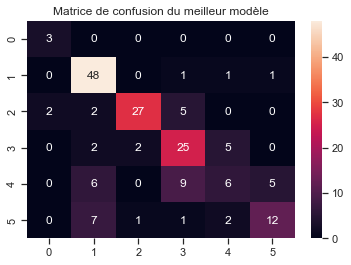

In [196]:
matrice_confusion = confusion_matrix(y_te, choix.predict(X_test_fs))
sns.heatmap(matrice_confusion, annot=True, fmt='d').set(title="Matrice de confusion du meilleur modèle")

On remarque l'on prédit assez mal la 5ème catégorie, c'est à dire les PC entre 800 et 1150 euros.

In [235]:
def tableau_comparaison(y_true:np.array, y_pred:np.array, nb_obs:int):
    """Fonction permettant de récupérer les valeurs réelles et prédites et de les comparer
        pour déterminer si elles sont équivalentes ou non. Le tout est présenté dans un tableau.
    """
    liste_bon_mauvais=[]
    for obs in range(len(y_true)):
        if y_pred[obs] == y_true[obs]:
            liste_bon_mauvais.append("Bon")
        else:
            liste_bon_mauvais.append("Mauvais")
            
    tab_res= Table()
    tab_res.add_column("Valeurs Réelles")
    tab_res.add_column("Valeurs Prédites")
    tab_res.add_column("Correspondance")
    for obs_2 in range(nb_obs):
         tab_res.add_row(str(y_true[obs_2]), str(y_pred[obs_2]), liste_bon_mauvais[obs_2])
    print(tab_res)

In [234]:
tableau_comparaison(y_true, y_pred, 10)

# Machine learning Regression

In [ ]:
data = pd.read_csv("data_nettoyee.csv")
data = data.replace(np.NaN, True)
data = data*1
data = data.drop(columns={"index", "Résolution"})
data = pd.get_dummies(data, columns=["Systeme_exploitation","Marque", "Processeur"], drop_first=False)
data.apply(pd.to_numeric)

## Machine learning models

In [256]:
resultats_cont = dict()

In [257]:
Y = data["Prix"]
X = data.drop("Prix", axis=1)

In [258]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y)

In [259]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", LinearRegression()),
    ]
)

In [260]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        "Reg__fit_intercept": [True, False],
    },
)
g.fit(X_tr, y_tr)
resultats_cont["LinearRegression"] = g

In [261]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", KNeighborsRegressor()),
    ]
)

In [262]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        "Reg__n_neighbors": [3, 5, 7, 9, 15]
    },
)
g.fit(X_tr, y_tr)
resultats_cont["KNN"] = g

In [263]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", Ridge()),
    ]
)

In [264]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        "Reg__fit_intercept": [True, False],
        "Reg__alpha": [0.01, 0.1, 1., 10.],
        "Reg__solver": ["svd", "lsqr"],
    },
)
g.fit(X_tr,y_tr)
resultats_cont["Ridge"] = g

In [265]:
resultats_cont["Lasso"] = "Ne converge pas"

In [266]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", ElasticNet()),
    ]
)

In [267]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        "Reg__fit_intercept": [True, False],
        "Reg__alpha": [0.1, 1., 10.],
        "Reg__l1_ratio": [0.1, 0.5, 0.9],
        "Reg__max_iter": [10000, 30000, 50000, 70000],
    },
    n_jobs=-1,
)
g.fit(X_tr, y_tr) 
resultats_cont["ElasticNet"] = g

In [268]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", SVR()),
    ]
)

In [269]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        "Reg__C": [0.1, 1., 10.],
        "Reg__epsilon": [0.05, 0.1, 0.5],
    },
    n_jobs=-1,
)
g.fit(X_tr, y_tr)
resultats_cont["SVR"] = g

In [270]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", RandomForestRegressor()),
    ]
)

In [271]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        "Reg__n_estimators": [50, 100],
    },
    n_jobs=-1,
)
g.fit(X_tr, y_tr)
resultats_cont["RandomForest"] = g

In [272]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", MLPRegressor()),
    ]
)


In [273]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        'Reg__hidden_layer_sizes': [(100,), (50, 50), (25, 50, 25), (50,50,50), (50,100,50)],
        "Reg__max_iter": [500, 1000, 5000],
    },
    n_jobs=-1,
)
g.fit(X_tr, y_tr)
resultats_cont["Neural Network"] = g

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [274]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", GradientBoostingRegressor()),
    ]
)

In [275]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        "Reg__n_estimators": [50, 100, 200],
    },
    n_jobs=-1,
)
g.fit(X_tr, y_tr)
resultats_cont["GradientBoost"] = g

In [276]:
p = Pipeline(
    [
        ("Norm", MinMaxScaler()),
        ("Reg", AdaBoostRegressor()),
    ]
)

In [277]:
g = GridSearchCV(
    p,
    {
        'Norm__feature_range': [(-1., 1.), (0., 1.)],
        "Reg__n_estimators": [50, 100, 200],
    },
    n_jobs=-1,
)
g.fit(X_tr, y_tr)
resultats_cont["Ada"] = g

## Résultats 

In [278]:
for modele, meilleur in resultats_cont.items():
    try:
        print(f"{modele}: score = {meilleur.best_score_}")
    except:
        print(f"{modele} : Converge pas")

Le meilleur semble être les réseaux de neurones mais ces algorithmes ne s'appliquent vraiment pas aux données.

In [279]:
choix_cont = resultats_cont["Neural Network"]

In [280]:
choix_cont.score(X_tr,y_tr)

0.30233198301145836

In [281]:
choix_cont.score(X_te,y_te)

0.5242946186320082